# Setup

In [ ]:
pip install mesa

# Model

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Wed Sep  2 05:57:29 2020

@author: Albert Yosua
"""

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import networkx as nx
import random
from scipy.stats import truncnorm

class IndvidualAgent(Agent):
    """ An agent."""
    def __init__(self, 
                 unique_id, model
                 ):
        super().__init__(unique_id, model)
        self.is_adult = 0
        self.school_id = None
        
        # TODO: must be calculated automatically
        self.household_contact_weight = 0
        self.school_contact_weight = 0

        # Check whether an agent has a contact with the infectious agent
        self.is_exposed = 0

        # Transition status
        # 0: S - susceptible
        # 1: L_A - latent asymptomatic
        # 2: L_S - latent symptomatic
        # 3: P_S - presymptomatic
        # 4: I_A - infectious asymptomatic
        # 5: I_S - infectious symptomatic
        # 6: H - hospitalized
        # 7: ICU - hospitalized in ICU
        # 8: R - recovered        
        # 9: M - stay at home
        self.status = 0
        
        self.incubation_period = 0


            
    def step(self):
        # Transition status
        # 6: H - hospitalized
        # 7: ICU - hospitalized in ICU
        # 8: R - recovered
        # 9: M - stay at home
        if self.status not in [6, 7, 8, 9]:
            # Contact with others inside the household
    #        contact_in_household(self)
            contact_in_household_2(self)
            
            # Contact with others inside the school  
            t = self.model.schedule.time
    #        if t % 7 != 5 and t % 7 != 6 and (t < 10 or t > 20):
#            if t % 7 != 5 and t % 7 != 6:
#            if t % 7 != 5 and t % 7 != 6 and (t < 5):
            if t % 7 != 5 and t % 7 != 6 and \
                (t < self.model.school_closure[0] or \
                 t >= self.model.school_closure[1]):
#                print(t)
                if self.is_adult == 0:
    #                contact_in_school(self)
                    contact_in_school_2(self)
        
        # If already infected, check the incubation period
        update_status(self)
        
#        print(self.model.schedule.time)

#def increase_incubation_period(self):
#    pass


        
def update_status(self):
    # Transition status
    # 0: S - susceptible
    # 1: L_A - latent asymptomatic
    # 2: L_S - latent symptomatic
    # 3: P_S - presymptomatic
    # 4: I_A - infectious asymptomatic
    # 5: I_S - infectious symptomatic
    # 6: H - hospitalized
    # 7: ICU - hospitalized in ICU
    # 8: R - recovered
    # 9: M - stay at home
    if self.status == 1: # L_A
        if self.incubation_period > self.model.epsilon_a:
            self.incubation_period = 0
            self.status = 4 # L_A -> I_A
            
    elif self.status == 2: # L_S
        if self.incubation_period > self.model.epsilon_s:
            self.incubation_period = 0
            self.status = 3 # L_S -> P_S
            
    elif self.status == 3: # P_S
        if self.incubation_period > self.model.epsilon_s:
            self.incubation_period = 0
            self.status = 5 # P_S -> I_S
            
    elif self.status == 4: # I_A
        if self.incubation_period > self.model.mu:
            self.incubation_period = 0
            self.status = 8 # I_A -> R
            
    elif self.status == 5: # I_S
        if self.incubation_period > self.model.mu:
            self.incubation_period = 0
            # Check whether hospitalization is needed
            r = random.uniform(0, 1)
            if r < self.model.alpha_group_3:
                # Need hospitalization
                self.status = 9 # I_S -> M
            else:
                self.status = 8 # I_S -> R
                
    elif self.status == 9: # M
        if self.incubation_period > self.model.delta:
            self.incubation_period = 0
            # Check whether ICU is needed
            r = random.uniform(0, 1)
            if r < self.model.chi_group_3:
                # Need ICU
                self.status = 7 # M -> ICU
            else:
                self.status = 6 # M -> H
                
    elif self.status == 6: # H
        if self.incubation_period > self.model.mu_H:
            self.incubation_period = 0
            self.status = 8 # H -> R
    
    elif self.status == 7: # ICU
        if self.incubation_period > self.model.mu_ICU:
            self.incubation_period = 0
            self.status = 8 # I_A -> R

def contact_in_school_2(self):
    try:
        sc_contacts = [n for n in self.model.S.neighbors(self.unique_id)]
    except:
        print('Error for this ID:', self.unique_id)    
                
    # Contact other agents multiple times
    for contact_id in sc_contacts:
                   
        for _ in range(self.model.school_contact):
          # Select another agent to contact
#          contact_id = random.choice(sc_contacts)          
          
          # Check with the contact weight before proceeding        
    #      r = random.randint(0, 100)
#          r = 0
          r = random.uniform(0, 1)
          if r < self.school_contact_weight:
            # Get the contact's details
            contact = next(a for a in self.model.schedule.agents 
                           if a.unique_id == contact_id)
            
            # Skip if another agent has already exposed 
            # TODO: what if the agent has been recovered?
            if contact.is_exposed == 1:
              continue
    
            # Perform the actual contact
            is_just_exposed = 0
            r = random.uniform(0, 1)
            if self.status == 3: # P_S
              if r < self.model.beta_S:
                is_just_exposed = 1
            elif self.status == 4: # I_A              
              if r < self.model.r_beta:
                is_just_exposed = 1
            elif self.status == 5: # I_S
              if r < self.model.beta:
                is_just_exposed = 1
    
            # Check whether the exposed contact becomes latent asymptomatic
            if is_just_exposed == 1:
              contact.is_exposed = 1              
              r = random.uniform(0, 1)
              if r < self.model.p:
                contact.status = 1 # L_A
              else:
                contact.status = 2 # L_S           

def contact_in_household_2(self):
    # print(self.unique_id, 
    #       [n for n in self.model.H.neighbors(self.unique_id)])
    
    hh_contacts = [n for n in self.model.H.neighbors(self.unique_id)]
#    print(hh_contacts)
    
    # Contact other agents multiple times
    for contact_id in hh_contacts:
        
        for _ in range(self.model.household_contact):
          # Select another agent to contact
#          contact_id = random.choice(hh_contacts)          
          
          # Check with the contact weight before proceeding        
    #      r = random.randint(0, 100)
#          r = 0
          r = random.uniform(0, 1)
          if r < self.household_contact_weight:
            # Get the contact's details
            contact = next(a for a in self.model.schedule.agents 
                           if a.unique_id == contact_id)
            
            # Skip if another agent has already exposed 
            # TODO: what if the agent has been recovered?
            if contact.is_exposed == 1:
              continue
    
            # Perform the actual contact
            is_just_exposed = 0
            r = random.uniform(0, 1)
            if self.status == 3: # P_S
              if r < self.model.beta_S:
                is_just_exposed = 1
            elif self.status == 4: # I_A              
              if r < self.model.r_beta:
                is_just_exposed = 1
            elif self.status == 5: # I_S
              if r < self.model.beta:
                is_just_exposed = 1
    
            # Check whether the exposed contact becomes latent asymptomatic
            if is_just_exposed == 1:
              contact.is_exposed = 1              
              r = random.uniform(0, 1)
              if r < self.model.p:
                contact.status = 1 # L_A
              else:
                contact.status = 2 # L_S                
            
def contact_in_school(self):
    try:
        sc_contacts = [n for n in self.model.S.neighbors(self.unique_id)]
    except:
        print(self.unique_id)
#    print(hh_contacts)
    
    # Contact other agents multiple times
    for _ in range(self.model.school_contact):
      # Select another agent to contact
      contact_id = random.choice(sc_contacts)          
      
      # Check with the contact weight before proceeding        
#      r = random.randint(0, 100)
      r = 0
      if r < self.school_contact_weight:
        # Get the contact's details
        contact = next(a for a in self.model.schedule.agents 
                       if a.unique_id == contact_id)
        
        # Skip if another agent has already exposed 
        # TODO: what if the agent has been recovered?
        if contact.is_exposed == 1:
          continue

        # Perform the actual contact
        is_just_exposed = 0
        r = random.uniform(0, 1)
        if self.status == 3: # P_S
          if r < self.model.beta_S:
            is_just_exposed = 1
        elif self.status == 4: # I_A              
          if r < self.model.r_beta:
            is_just_exposed = 1
        elif self.status == 5: # I_S
          if r < self.model.beta:
            is_just_exposed = 1

        # Check whether the exposed contact becomes latent asymptomatic
        if is_just_exposed == 1:
          contact.is_exposed = 1              
          r = random.uniform(0, 1)
          if r < self.model.p:
            contact.status = 1 # L_A
          else:
            contact.status = 2 # L_S            

def contact_in_household(self):
    # print(self.unique_id, 
    #       [n for n in self.model.H.neighbors(self.unique_id)])
    
    hh_contacts = [n for n in self.model.H.neighbors(self.unique_id)]
#    print(hh_contacts)
    
    # Contact other agents multiple times
    for _ in range(self.model.household_contact):
      # Select another agent to contact
      contact_id = random.choice(hh_contacts)          
      
      # Check with the contact weight before proceeding        
#      r = random.randint(0, 100)
      r = 0
      if r < self.household_contact_weight:
        # Get the contact's details
        contact = next(a for a in self.model.schedule.agents 
                       if a.unique_id == contact_id)
        
        # Skip if another agent has already exposed 
        # TODO: what if the agent has been recovered?
        if contact.is_exposed == 1:
          continue

        # Perform the actual contact
        is_just_exposed = 0
        r = random.uniform(0, 1)
        if self.status == 3: # P_S
          if r < self.model.beta_S:
            is_just_exposed = 1
        elif self.status == 4: # I_A              
          if r < self.model.r_beta:
            is_just_exposed = 1
        elif self.status == 5: # I_S
          if r < self.model.beta:
            is_just_exposed = 1

        # Check whether the exposed contact becomes latent asymptomatic
        if is_just_exposed == 1:
          contact.is_exposed = 1              
          r = random.uniform(0, 1)
          if r < self.model.p:
            contact.status = 1 # L_A
          else:
            contact.status = 2 # L_S

class PopulationModel(Model):
    """A model with some number of agents."""
    def __init__(self, 
                 household_numbers,
                 school_numbers,
                 school_closure,                 
                 seed=None
                 ):
        # Scheduler that activates each agents once per step
        self.schedule = RandomActivation(self)

        # For batch set up
        self.running = True
        
        # Parameters
#        self.num_agents = N
        self.school_closure = school_closure

        # Daily contacts
        household_contact = 4
        school_contact = 11    

        # Transmission process: susceptible -> latent -> infected -> removed

        # Transmission parameters 
        r = 0.5 # Relative infectiousness of asymptomatic individuals (%)
        p = 0.25 # Proportion of asymptomatic (%)
        k = 0.15 # Proportion of presymptomatic transmission (%)

        mu = 2.5 # Incubation period to removed (days)
        gamma = 2 # Presymptomatic period to infectious symptomatic (days)

        R_0 = 2.5 # Basic reproduction number

        # Transmission for symptomatic and asymptomatic individuals
        beta = R_0*(1/mu) / (p*r+(1-p)/(1-k)) 

        # Transmission for asymptomatic individuals
        r_beta = r*beta
        
        # Transmission for presymptomatic individuals
        beta_S = beta*(1/gamma)*k/((1/mu)*(1-k))
        
        # Incubation period (days)
        epsilon_a = 5 # From latent asymptomatic to infectious asymptomatic
        epsilon_s = 3 # From latent symptomatic to infectious presymptomatic
        
        # Symptomatic case hospitalization ratio (%)
        # TODO: add other age groups
        alpha_group_3 = 0.02672 # 18-49
        alpha_group_5 = 0.15465 # 65+
        
        # ICU case ratio among the hospitalized agents (%)
        # TODO: add other age groups
        chi_group_3 = 0.0538 # 18-49
        chi_group_5 = 0.4471 # 65+         
        
        delta = 2 # From home stay to hospital admission (days)        
        mu_H = 8 # Number of stays in the hospital until recovered (days)
        mu_ICU = 13 # Number of stays in the ICU until recovered (days)

        self.household_contact = household_contact
        self.school_contact = school_contact
        self.r = r
        self.p = p
        self.k = k
        self.mu = mu
        self.gamma = gamma
        self.R_0 = R_0
        self.beta = beta
        self.r_beta = r_beta
        self.beta_S = beta_S
        self.epsilon_a = epsilon_a
        self.epsilon_s = epsilon_s
        self.alpha_group_3 = alpha_group_3
        self.alpha_group_5 = alpha_group_5
        self.chi_group_3 = chi_group_3
        self.chi_group_5 = chi_group_5
        self.delta = delta
        self.mu_H = mu_H
        self.mu_ICU = mu_ICU
        
        

#        # Create agents with the same IDs as in the network
#        for i in range(6):
#          agent = IndvidualAgent(i, self)
#          self.schedule.add(agent)
          
        # Household network
        self.H = nx.Graph()
        
        household_total = household_numbers
        school_total = school_numbers
        school_ids = [i for i in range(school_total)]
        start_id = 0
              
        # For random household size list
        low = 3
        upp = 7
        mean = 3
        std = 1
#        a, b = (low - mean) / std, (upp - mean) / std
        random_size = get_truncated_normal(mean, std, low, upp)
        household_size_list = random_size.rvs(size=household_total)
        household_size_list = household_size_list.round().astype(int)
        
        for i in range(household_total):
          # Get the household size between 3 and 5
#          r = random.randint(3, 7)
#          household_size_list.append(r)
          r = household_size_list[i]
          count = 0
          for i in range(start_id, start_id + r):
              # Create an agent with specific ID
              agent = IndvidualAgent(i, self)
              self.schedule.add(agent)
              
              count += 1
              if count <= 2: # Adult
                  agent.is_adult = 1
              else: # Children
                  # Set the school id for this agent 
                  agent.school_id = random.choice(school_ids)
                  
              # Set the household contact weight
              w_H = 1 / (r - 1)
              agent.household_contact_weight = w_H
                                                     
          self.H.update(nx.complete_graph(range(start_id, start_id + r)))
          start_id += r
          
        # TODO: create distribution of household size data
        self.household_size_list = household_size_list
        
        # School network
        self.S = nx.Graph()
        for school_id in school_ids:
            # Get the students IDs of each school
            students = [s.unique_id for s in self.schedule.agents 
                        if s.school_id == school_id]        
            
            self.S.update(nx.complete_graph(students))
            
            # Set the school contact weight
            w_S = 1 / (len(students) - 1)
            # TODO: is there any optimal solution?
            for s in self.schedule.agents:
                if s.school_id == school_id:
                    s.school_contact_weight = w_S
                    
            
        # Set initial infected agents
        self.new_infected_agents_total = 2
        self.prev_infected_agents_total = self.new_infected_agents_total
#        total_agents = len(self.schedule.agents)
#        infected_agent_ids = random.sample(range(total_agents), 2)
        infected_agents = random.sample(self.schedule.agents, 
                                        self.new_infected_agents_total)
        for agent in infected_agents:
            agent.is_exposed = 1
            agent.status = 5
        
          
#        # Household network
#        self.H = nx.Graph()

#        self.H.add_edge(0, 1)
#        self.H.add_edge(0, 2)
#        self.H.add_edge(1, 2)
#
#        self.H.add_edge(3, 4)
#        self.H.add_edge(3, 5)
#        self.H.add_edge(4, 5)


        self.datacollector = DataCollector(
        # A function to call
        model_reporters={'exposed_agents': get_exposed_agents,
                         'new_exposed_agents': get_new_exposed_agents,
                         'hospitalized_agents': get_hospitalized_agents,
                         'reproductive_number': get_reproductive_number,
                         'recovered_agents': get_recovered_agents
                         },  

        # An agent attribute
        agent_reporters={
                         })  

    def step(self):
        '''Advance the model by one step.'''
        self.schedule.step()
        
        # Increase incubation period
        for agent in self.schedule.agents:
                # Transition status
                # 0: S - susceptible
                # 8: R - recovered
            if agent.status not in [0, 8]:
                agent.incubation_period += 1    
        
        # Update reproduction number as new agents become immune
        recovered_agents_total = sum(1 for agent 
                                     in self.schedule.agents 
                                     if agent.status == 8)
        agents_total = len(self.schedule.agents)
        susceptible_fraction = (agents_total - recovered_agents_total) / \
                               agents_total
        self.R_0 = self.R_0 * susceptible_fraction
        
        # Transmission for symptomatic and asymptomatic individuals
        self.beta = self.R_0*(1/self.mu) / \
                    (self.p*self.r+(1-self.p)/(1-self.k)) 

        # Transmission for asymptomatic individuals
        self.r_beta = self.r*self.beta
        
        # Transmission for presymptomatic individuals
        self.beta_S = self.beta*(1/self.gamma)*self.k/((1/self.mu)*(1-self.k))
        
        
        # Collect data after performing action defined in step function
        self.datacollector.collect(self)
        
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
        
def get_exposed_agents(model):
    total = sum(1 for agent 
                in model.schedule.agents 
                if agent.is_exposed == 1)    
    return total

def get_new_exposed_agents(model):
    current_exposed_agents_total = get_exposed_agents(model)
    total =  current_exposed_agents_total - model.prev_infected_agents_total 
#    print(total, current_exposed_agents_total, model.prev_infected_agents_total)
    model.prev_infected_agents_total = current_exposed_agents_total
    return total

def get_hospitalized_agents(model):
    total = sum(1 for agent 
                in model.schedule.agents 
                if agent.status == 6)
    return total

def get_recovered_agents(model):
    total = sum(1 for agent 
                in model.schedule.agents 
                if agent.status == 8)
    return total

def get_reproductive_number(model):
    return model.R_0

# Model Simulation - School Closure from Day 15 to 20

Total agents: 1133


Text(0, 0.5, 'Recovered')

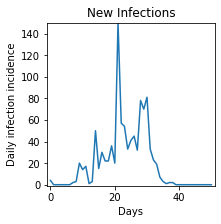

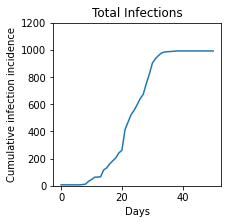

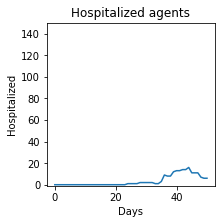

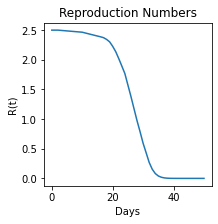

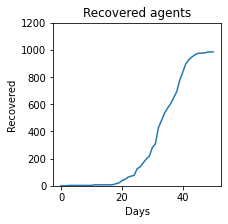

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed Sep  2 21:17:35 2020

@author: Albert Yosua
"""

# from model import PopulationModel 
import networkx as nx
import matplotlib.pyplot as plt

days = 51

model = PopulationModel(household_numbers=300, # Household numbers
                        school_numbers=2,
                        school_closure=[15,20])

#pos = nx.spring_layout(model.H,
#                       k=0.15,
#                       iterations=8)
#nx.draw_networkx(model.H,
#                 node_color='white',
#                 pos=pos)

print('Total agents:', len(model.schedule.agents))

for i in range(days):
  model.step()
#  print(i)
  
#for a in model.schedule.agents:
#    print(a.status)

model_data = model.datacollector.get_model_vars_dataframe()

model_data.new_exposed_agents.plot(figsize=(3,3),
                                   xlim=(-1,51),
                                   ylim=(-1,150),
                                   title='New Infections')
plt.xlabel('Days')
plt.ylabel('Daily infection incidence')
plt.figure()
model_data.exposed_agents.plot(figsize=(3,3),
                               ylim=(-1,1200),                               
                               title='Total Infections')
plt.xlabel('Days')
plt.ylabel('Cumulative infection incidence')
plt.figure()
model_data.hospitalized_agents.plot(figsize=(3,3),
                                    ylim=(-1,150),
                                    title='Hospitalized agents')
plt.xlabel('Days')
plt.ylabel('Hospitalized')
plt.figure()
model_data.reproductive_number.plot(figsize=(3,3),
                                    # ylim=(-1,5),
                                    title='Reproduction Numbers')
plt.xlabel('Days')
plt.ylabel('R(t)')
plt.figure()
model_data.recovered_agents.plot(figsize=(3,3),
                                 ylim=(-1,1200),
                                 title='Recovered agents')
plt.xlabel('Days')
plt.ylabel('Recovered')


#for a in model.schedule.agents:
#    if a.is_adult == 0:
#        print(a.unique_id, a.school_id)

# Model Simulation - School Closure from Day 15 to 30

Total agents: 1115


Text(0, 0.5, 'Recovered')

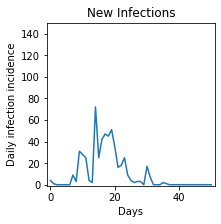

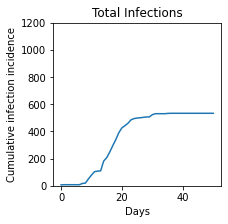

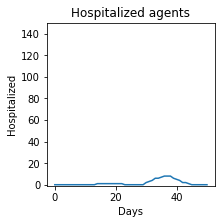

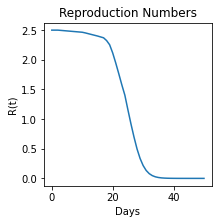

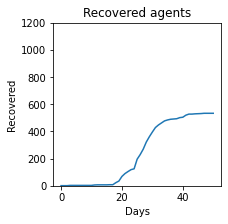

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed Sep  2 21:17:35 2020

@author: Albert Yosua
"""

# from model import PopulationModel 
import networkx as nx
import matplotlib.pyplot as plt

days = 51

model = PopulationModel(household_numbers=300, # Household numbers
                        school_numbers=2,
                        school_closure=[15,30])

#pos = nx.spring_layout(model.H,
#                       k=0.15,
#                       iterations=8)
#nx.draw_networkx(model.H,
#                 node_color='white',
#                 pos=pos)

print('Total agents:', len(model.schedule.agents))

for i in range(days):
  model.step()
#  print(i)
  
#for a in model.schedule.agents:
#    print(a.status)

model_data = model.datacollector.get_model_vars_dataframe()

model_data.new_exposed_agents.plot(figsize=(3,3),
                                   xlim=(-1,51),
                                   ylim=(-1,150),
                                   title='New Infections')
plt.xlabel('Days')
plt.ylabel('Daily infection incidence')
plt.figure()
model_data.exposed_agents.plot(figsize=(3,3),
                               ylim=(-1,1200),                               
                               title='Total Infections')
plt.xlabel('Days')
plt.ylabel('Cumulative infection incidence')
plt.figure()
model_data.hospitalized_agents.plot(figsize=(3,3),
                                    ylim=(-1,150),
                                    title='Hospitalized agents')
plt.xlabel('Days')
plt.ylabel('Hospitalized')
plt.figure()
model_data.reproductive_number.plot(figsize=(3,3),
                                    # ylim=(-1,5),
                                    title='Reproduction Numbers')
plt.xlabel('Days')
plt.ylabel('R(t)')
plt.figure()
model_data.recovered_agents.plot(figsize=(3,3),
                                 ylim=(-1,1200),
                                 title='Recovered agents')
plt.xlabel('Days')
plt.ylabel('Recovered')


#for a in model.schedule.agents:
#    if a.is_adult == 0:
#        print(a.unique_id, a.school_id)